##### Author: Pierre LIENHART
##### Contact: pierre.lienhart@gmail.com

# Datadog data science homework - Problem 1

## Problem statement

The following problem is meant to test your data analysis and quantitative skills. We do not expect you to be familiar with anything abstruse such as queueing theory or even time series analysis. You have been provided a file, app_logs.txt, which contains simulated application logs in the following format:

Column 1: # seconds since time t=0

Column 2: # requests processed since last log

Column 3: Mean response time for requests processed since last log

The logging frequency is 1 per second, but there are no logs for seconds in which there were no requests. The data span two simulated weeks and were generated under an idealized/simplified model in which there is a single application server which processes requests sequentially using a single thread.

If a request arrives while the server is busy, it waits in a queue until the server is free to process it. There is no limit to the size of the queue.

We define "week 2" to begin at second 626400 (6 am on the 8th day).

### Packages and input data file import

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns 

sns.set_style("darkgrid")

In [2]:
SRC_FILE_PATH = './data/app_logs.txt'

In [3]:
sep='\t'
names = ['time', 'processed_req_count', 'mean_resp_time']
schema = {'time': 'int32', 'processed_req_count': 'int32', 'mean_resp_time': 'float32'}

df = pd.read_csv(SRC_FILE_PATH, header=None, names=names, sep=sep, decimal='.', dtype=schema)

df.head()

,time,processed_req_count,mean_resp_time
0,21601,2,0.052
1,21602,1,0.034
2,21603,5,0.077
3,21604,4,0.064
4,21605,1,0.138


In [4]:
df.describe()

,time,processed_req_count,mean_resp_time
count,1.188061e+06,1.188061e+06,1.188061e+06
mean,6.261069e+05,7.545333e+00,2.447917e-01
std,3.490834e+05,3.909620e+00,1.235209e+00
min,2.160100e+04,1.000000e+00,1.500000e-02
25%,3.235950e+05,4.000000e+00,8.500000e-02
50%,6.272370e+05,8.000000e+00,1.190000e-01
75%,9.284170e+05,1.000000e+01,1.880000e-01
max,1.231198e+06,3.100000e+01,4.725000e+01


In [5]:
df.isna().apply(sum, axis=0)

time                   0
processed_req_count    0
mean_resp_time         0
dtype: int64

We deduce from the cell above that the dataset does not contain any missing value.

### Question 1
How much has the mean response time (specifically, the mean of the response times for each individual request) changed from week 1 to week 2?

In [6]:
df['week'] = np.where(df.time < 626400, 1, 2)

df.head()

,time,processed_req_count,mean_resp_time,week
0,21601,2,0.052,1
1,21602,1,0.034,1
2,21603,5,0.077,1
3,21604,4,0.064,1
4,21605,1,0.138,1


In [7]:
df_weekly_mean_resp_time = df.groupby('week', as_index=False)['mean_resp_time']\
    .agg(lambda df: np.average(df.mean_resp_time, weights=df.processed_req_count))

weekly_mean_1, weekly_mean_2 = df_weekly_mean_resp_time['mean_resp_time']
weekly_change = (weekly_mean_2-weekly_mean_1)*100/weekly_mean_1

print('Change in weekly mean response time: {:+4.2f}%'.format(weekly_change))
df_weekly_mean_resp_time

Change in weekly mean response time: +153.52%


,week,mean_resp_time
0,1,0.185094
1,2,0.469257


We deduce from the cell above that the mean response time per request **increased by approximately 2.5 times** from week 1 to week 2. 

### Question 2 
Create a plot illustrating the distribution of the amount of server time it takes to process a request—excluding the time the request spends waiting in the queue (There is no need to try to fit the distribution.)

--- 

We discriminate two cases: 
* The total amount of processing and waiting time (total response time) for all the requests processed a the given time interval $\Delta t$ **is shorter** than $\Delta t$. For example, considering a time interval $\Delta t$ of 1s during which 3 requests have been processed with a mean response time of 0.1s. The total amount of processing and waiting time is in that case shorter (0.3s) than the length of the time interval (1s).
* The total amount of processing and waiting time for all the requests processed a the given time interval $\Delta t$ **is longer** than $\Delta t$.

In the first case, we can make the assumption that no request had to wait to be processed considering that the server spent part of the time inteval idle. We then approximate the mean server time with the mean response time. This assumption may be risky: even if the server had some spare capacity for that time interval, if two requests were submitted almost simultaneously, then one of them needed to wait in the queue. In that case we do not have enough information to break down the processing time into server and waiting time. We will neglect this effect in the following calculations.

In the second case, the server has been continuously processing requests over the duration of the interval. The mean server time per request can in that case be approximated by dividing the request count processed over the time interval $X$ by the length of the time interval $\Delta t$. From a rigorous point of view, we are actually certain that at least $X-1$ requests were processed in the interval. It is indeed likely that the processing of the first request treated in a given interval begun in the preceding interval. We will neglect this effect in the following calculations.

In [8]:
df['tot_resp_time'] = df['processed_req_count']*df['mean_resp_time']
df['interval_duration'] = df['time'].diff()
df['processed_req_per_sec'] = df['processed_req_count']/df['interval_duration']

df.head()

,time,processed_req_count,mean_resp_time,week,tot_resp_time,interval_duration,processed_req_per_sec
0,21601,2,0.052,1,0.104,NaN,NaN
1,21602,1,0.034,1,0.034,1.0,1.0
2,21603,5,0.077,1,0.385,1.0,5.0
3,21604,4,0.064,1,0.256,1.0,4.0
4,21605,1,0.138,1,0.138,1.0,1.0


In [9]:
df['mean_server_time'] = np.where(df.tot_resp_time > df.interval_duration,
                                  df.interval_duration/df.processed_req_count, 
                                  df.mean_resp_time)

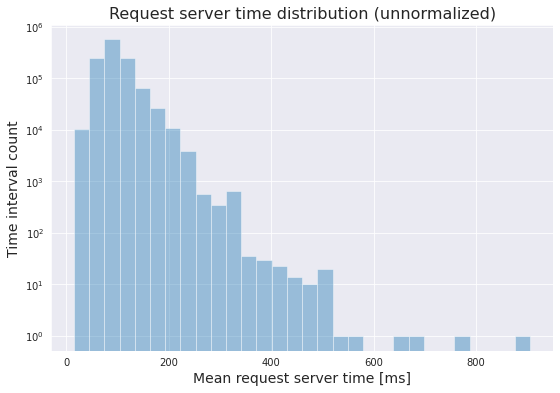

In [13]:
fig, ax = plt.subplots(figsize=(9,6))

ax = sns.distplot(df['mean_server_time']*1000, kde=False, bins=30, ax=ax)
# To get a normalized distribution plot, simply add norm_hist=True to sns.distplot

ax.set_yscale('log')

ax.set_xlabel('Mean request server time [ms]', size=14)
ax.set_ylabel('Time interval count', size=14)

ax.set_title('Request server time distribution (unnormalized)', size=16);

Notice: We deemed an unnormalized distribution plot more illustrative.

### Question 3
Propose a potential cause for the change in response times. Give both a qualitative answer as if you were explaining it to a client and a quantitative answer as if you were explaining it to a statistician. Create 1 or 2 plots to support and illustrate your argument.

In [54]:
df_weekly_req_count = df.groupby('week', as_index=False)['processed_req_count']\
    .sum()

weekly_count_1, weekly_count_2 = df_weekly_req_count['processed_req_count']
weekly_change = (weekly_count_2-weekly_count_1)*100/weekly_count_1

print('Change in weekly processed request count: {:+4.2f}%'.format(weekly_change))
df_weekly_req_count

Change in weekly processed request count: +5.97%


,week,processed_req_count
0,1,4352253
1,2,4612063


In [55]:
df_weekly_mean_server_time = df.groupby('week', as_index=False)['mean_server_time']\
    .mean()

weekly_mean_1, weekly_mean_2 = df_weekly_mean_server_time['mean_server_time']
weekly_change = (weekly_mean_2-weekly_mean_1)*100/weekly_mean_1

print('Change in weekly mean server time: {:+4.2f}%'.format(weekly_change))
df_weekly_mean_server_time

Change in weekly mean server time: -3.42%


,week,mean_server_time
0,1,0.097273
1,2,0.093948


Contrary to the mean response time, the estimated mean server time does not change significantly from week 1 to week 2 (+153% vs -3%). This result is consistent with the distribution we obtained in Question 2 which peaks hard (remember that the y-scale is a log scale) around 0.1s/request. We also notice a increase in the amount of submitted (and processed request) from week 1 to week 2 (+6%).

The average server time corresponds to ~10.5 requests processed per second. We will now plot the processed request count and the response time both as a function of time but we will first reduce de size of the dataset to make the  plotting task quicker.

Notice that a rate of 10.5 requests processed per second corresponds to a rate of 3150 requests processed per 5-minute-intervals.

In [56]:
def agg_func(df):
    return pd.Series({
        'time': df.time.iloc[0],
        'processed_req_count': df.processed_req_count.sum(),
        'mean_server_time': np.average(df.mean_server_time, weights=df.processed_req_count),
        'mean_resp_time': np.average(df.mean_resp_time, weights=df.processed_req_count)
    })

In [65]:
SMOOTHING_INTERVAL = 5*60 # in seconds. Ex: 5min => 5*60

df['larger_time_interval'] = df['time']//(SMOOTHING_INTERVAL)

aggregated_cols = ['time', 'processed_req_count', 'mean_server_time', 'mean_resp_time']

df_agg = df.dropna()\
    .groupby('larger_time_interval', as_index=False)[aggregated_cols]\
    .agg(agg_func)

df_agg['log_mean_resp_time'] = np.log10(df_agg['mean_resp_time'])

In [58]:
df_agg.head()

,larger_time_interval,time,processed_req_count,mean_server_time,mean_resp_time,log_mean_resp_time
0,72,21602.0,578.0,0.081287,0.081287,-1.089978
1,73,21900.0,671.0,0.086256,0.086256,-1.064209
2,74,22200.0,714.0,0.084277,0.084277,-1.074289
3,75,22500.0,813.0,0.085143,0.085143,-1.069853
4,76,22800.0,910.0,0.088237,0.088760,-1.051781


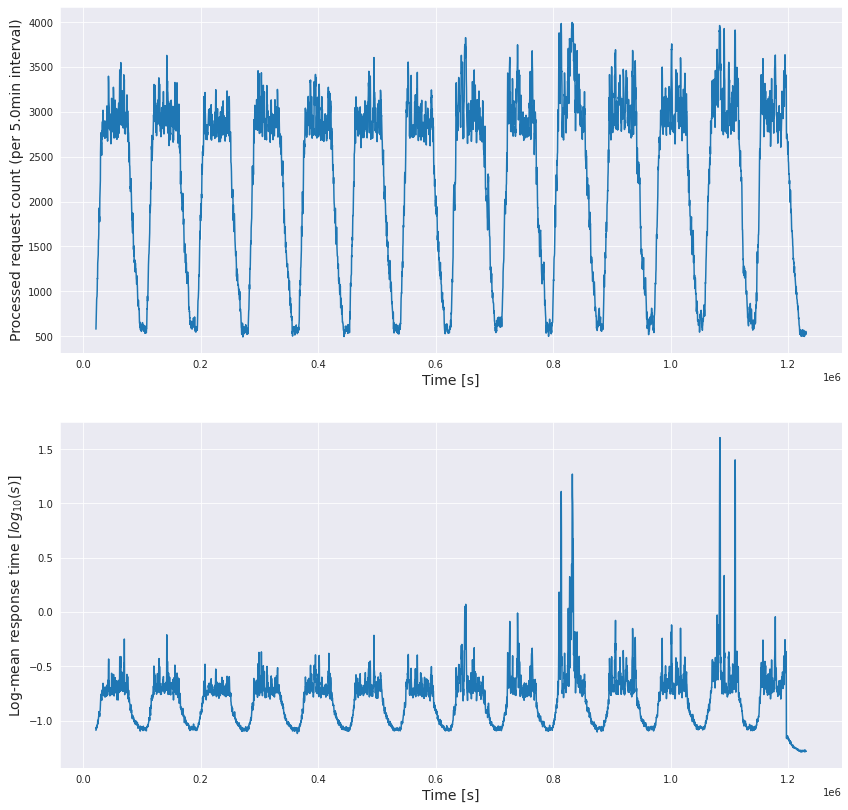

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

axe_1 = axes[0]

axe_1 = sns.lineplot(data=df_agg, x='time', y='processed_req_count', ax=axe_1)

axe_1.set_xlabel('Time [s]', size=14)
axe_1.set_ylabel('Processed request count (per {:2.1f}min interval)'.format(SMOOTHING_INTERVAL/60), size=14)

axe_2 = axes[1]

axe_2 = sns.lineplot(data=df_agg, x='time', y='log_mean_resp_time', ax=axe_2)

axe_2.set_xlabel('Time [s]', size=14)
axe_2.set_ylabel(r'Log-mean response time [$log_{10}(s)$]', size=14);

We can see from the above charts that the spikes for the mean response time seem to coincide with the spikes in the processed request count (see Quantitative answer for further explanations): the highest response time appear when the load is the highest. This strongly suggests that our application is saturating.

Remarks on the variables:
* High 5-minute averaged response times point to situations in which queues have built up (unusually long requests are smoothed out).
* High 5-minute averaged processed request counts points to situations in which the load is high: to achieve high 5-minute counts, the application had to run continuously at a rate that can be a bit higher than its average depending on how complex the submitted requests are. 5-minute averaged processed request counts can be considered as a reasonable proxy for load (which is unknown).

#### Qualitative answer
Peak load in week 2 has our server application to saturate. Data analysis showed that the decrease in performance (increase in response time) is not due to the application itself which keeps processing requests roughly at the same rate over the period: 10.5 requests/sec (or 3150 requests/5min). During week 2, the daily load plateau (as well as peaks) gets close and higher than this average processing capacity. As a consequence, queues start to build up: each new request has to wait for all the ones submitted earlier to be processed. Getting back to low response times requires to consume the entire queue (or a least to keep it to a minimum). This can take time as requests keep being submitted at the same time. For the queue to decrease, the rate of request submission needs to decrease enough to allow the server application to process the incoming requests and consume the queue at the same time. This process can take time or even never happen if the submission rate keeps being higher that the processing rate (and the response time will then never stop increasing).

We can see from the plot above that we could have anticipated this situation during week 1. We can indeed see that the application was already close from its maximum capacity and that a few queues built up during the week with an associated increase in processing time. The 6% increase in load in week 2 was enough to make the application saturate as it was already close from saturation. 

We can use a metaphor to make the situation clearer. Think of the application server as an employee in a train station hall. The employee sells train tickets ("processes a request"), works in the only open shelter in the hall and takes care of one customer at a time ("single application server which processes requests sequentially using a single thread"). Week 1 is quite busy but the employee manages to have just a few customer waiting for a reasonable time in the line. Week 2 however is the first week of summer break and our employee is still the only open shelter in the hall. He works as fast as during week 1 but he cannot keep the pace: long lines start to build up with customers waiting long minutes. The line only starts to decrease sometimes long after rush hours when our employee manages to work faster than the rate at which new customers arrive. 

#### Quantitative answer
Let's try to get more precise regarding this coincidence of peaks in processed request count and in mean response time. 

In [60]:
corr, pvalue = scipy.stats.spearmanr(df_agg.log_mean_resp_time, df_agg.processed_req_count)

print('Spearman correlation between ({:2.1f}min-averaged) log-mean reponse time and processed requests count:' 
      '{:5.4f} (p-value: {:5.4f})'.format(SMOOTHING_INTERVAL/60, corr, pvalue))

Spearman correlation between (5.0min-averaged) log-mean reponse time and processed requests count:0.9760 (p-value: 0.0000)


We see that there is a strong Spearman correlation between 5-minutes aggregated mean reponse times and processed requests counts. This means that there exist a strong monotonic relationship between these two variables. This relationship is significant as the p-value is well below any common error rate. This can be confirmed by plotting the scatter plot of the two variables (see below).

The monotonic relationship means that they both reach their quantiles "at the same time": in particular, they spike "at the same time". We can therefore state that there is a strong relationship between spikes in response time and spikes in processed request count. As averaged processed request counts can be considered as reasonnable proxies for load, we can conclude that there is a strong relationship between spikes in response time and spikes in load: the application is saturating.  

Notice: We initialy chose the 5 minute value rather arbitrarily but computing the correlation for different values (from 30s to 10min) always yields high values (at least 0.93, increasing with the strengh of the smoothing). Choosing a (reasonably) smaller or larger time interval for aggregation does not therefore change the above-described result.

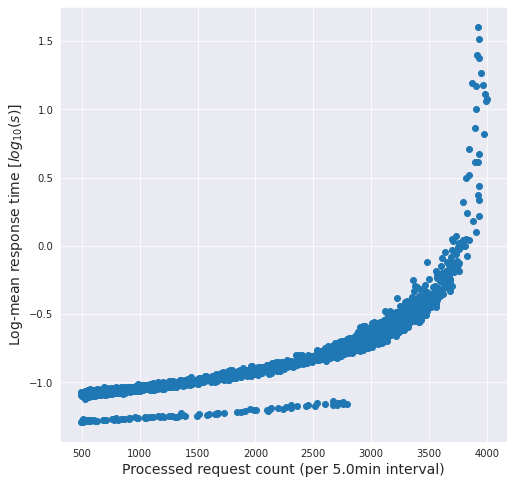

In [66]:
fig, ax = plt.subplots(figsize=(8,8))

plt.scatter(x=df_agg.processed_req_count, y=df_agg.log_mean_resp_time)

ax.set_xlabel('Processed request count (per {:2.1f}min interval)'.format(SMOOTHING_INTERVAL/60), size=14)
ax.set_ylabel(r'Log-mean response time [$log_{10}(s)$]', size=14);

We can see from the scatter plot that there is indeed a significant monotonic relationship betweed the (log) mean response time and the processed request count. 